In [2]:
import os
import torch
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import knn_graph, HeteroConv, GCNConv, Linear, SAGEConv 
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from random import shuffle
import numpy as np
# from torch_geometric.nn import GCNConv, Linear
from torch_geometric.utils import negative_sampling, dropout_edge
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from random import sample
from ipywidgets import IntProgress
from IPython.display import display
import time
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.model_selection import StratifiedKFold, train_test_split

In [3]:

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
instance_additionals = {}
set_sizes_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            # ng_dict[instance] = [[0 for i in range(101)]]
            ng_dict[instance] = []
        ng_dict[instance].append([int(i) for i in split_line_list[5:-1]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [4]:
ordered_difficulty = [(k,v) for k,v in set_sizes_dict.items()]
ordered_difficulty = sorted(ordered_difficulty, key=lambda tup: tup[1], reverse=True)
instances_to_add = [ordered_difficulty[i][0] for i in range(0,1000)]
# instances_remaining = [ordered_difficulty[i][0] for i in range(1000,len(ordered_difficulty))]
# easy_instances = sample(instances_remaining, 2000)
instance_list = instances_to_add #+ easy_instances

In [5]:
data_files_list = ["./export2/"+f for f in os.listdir("./export2") ]

for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

cnt = -1
with open("ng_outs_JLA.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 1:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            # ng_dict[instance] = [[0 for i in range(101)]]
            ng_dict[instance] = []
        ng_dict[instance].append([int(i) for i in split_line_list[5:]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        # add new instances
        instance_list.append(instance)
        if len(split_line_list[5:]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [12]:
data_list = []
# aux_data_list = []


for instance_name in instance_list:
    instance = instance_dict[instance_name]
    attr = []
    max_demand = -1
    capacity = instance_additionals[instance_name][0][1]
    for i in instance[1:]:
        demand = i[3]
        if demand > max_demand:
            max_demand = demand
        attr.append(i[1:] + instance_additionals[instance_name][0])
    
    y = torch.tensor(ng_dict[instance_name], dtype=torch.float)
    # x = nn.functional.normalize( torch.tensor(attr, dtype=torch.float) )
    x_stops = torch.tensor(attr, dtype=torch.float)
    x_depot = torch.tensor([instance[0][1:] + instance_additionals[instance_name][0]], dtype=torch.float)
    pos_depot = [[instance[0][1], instance[0][2]]]
    pos_stops = []
    tw_sets_dict = {}
    for i in instance[1:]:
        pos_stops.append([i[1], i[2]])
    pos_stops = torch.tensor(pos_stops, dtype=torch.double)
    pos_depot = torch.tensor(pos_depot, dtype=torch.double)
    route_neighbors = min(max(capacity//max_demand, 15), 25)
    edge_index = knn_graph(pos_stops[1:], route_neighbors)
    new_graph = HeteroData()
    new_graph["depot"].x = x_depot
    new_graph["stops"].x = x_stops
    new_graph["stops", "route", "stops"].edge_index = edge_index
    new_graph["depot", "departs", "stops"].edge_index = torch.tensor([
        [0 for _ in range(len(attr))],
        [i for i in range(len(attr))]
    ], dtype=torch.long)
    new_graph["stops", "return", "depot"].edge_index = torch.tensor([
        [i for i in range(len(attr))],
        [0 for _ in range(len(attr))]
    ], dtype=torch.long)
    new_graph["stops", "remember", "stops"].edge_index = y.nonzero().t().contiguous()
    new_graph["depot"].pos = pos_depot
    new_graph["stops"].pos = pos_stops
    data_list.append(new_graph)

In [12]:
print(data_list[0])
print(data_list[1])

HeteroData(
  depot={
    x=[1, 8],
    pos=[1, 2],
  },
  stops={
    x=[100, 8],
    pos=[100, 2],
  },
  (stops, route, stops)={ edge_index=[2, 495] },
  (depot, departs, stops)={ edge_index=[2, 100] },
  (stops, return, depot)={ edge_index=[2, 100] },
  (stops, remember, stops)={ edge_index=[2, 649] }
)
HeteroData(
  depot={
    x=[1, 8],
    pos=[1, 2],
  },
  stops={
    x=[100, 8],
    pos=[100, 2],
  },
  (stops, route, stops)={ edge_index=[2, 495] },
  (depot, departs, stops)={ edge_index=[2, 100] },
  (stops, return, depot)={ edge_index=[2, 100] },
  (stops, remember, stops)={ edge_index=[2, 628] }
)


In [53]:
print(data_list[0]["stops"].x.size())

torch.Size([100, 8])


In [13]:
def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False, edge_types=["route", "remember"])
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]
shuffle(labeled_graphs)

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=100, shuffle=True)
val_loader = DataLoader(val_size, batch_size=100, shuffle=False)
test_loader = DataLoader(test_size, batch_size=100, shuffle=False)

In [17]:
cnt = 0
for i in test_loader:
    if cnt == 0:
        print(i)
        cnt += 1

HeteroDataBatch(
  depot={
    x=[100, 8],
    pos=[100, 2],
    batch=[100],
    ptr=[101],
  },
  stops={
    x=[10000, 8],
    pos=[10000, 2],
    batch=[10000],
    ptr=[101],
  },
  (stops, route, stops)={
    edge_index=[2, 94450],
    edge_label=[10388],
    edge_label_index=[2, 10388],
  },
  (depot, departs, stops)={ edge_index=[2, 10000] },
  (stops, return, depot)={ edge_index=[2, 10000] },
  (stops, remember, stops)={
    edge_index=[2, 51522],
    edge_label=[5618],
    edge_label_index=[2, 5618],
  }
)


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ("stops", "route", "stops") : GCNConv(-1, hidden_channels),
                ("depot", "departs", "stops") : SAGEConv((-1, -1), hidden_channels),
                ("stops", "return", "depot"): SAGEConv((-1, -1), hidden_channels),
                ("stops", "remember", "stops") : GCNConv(-1, hidden_channels)
            })
            self.convs.append(conv)
        self.lin = Linear(hidden_channels, out_channels)

    def encode(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
            x_dict["stops"] = self.lin(x_dict["stops"])
            x_dict["depot"] = self.lin(x_dict["depot"])
        return x_dict

    def decode(self, z_dict, edge_label_index, edge_type=("stops", "remember", "stops")):
        # from ChatGPT
        # Decode edges of the specific type ("stops", "remember", "stops") by computing dot products
        src, dst = edge_label_index[0], edge_label_index[1]
        z_src = z_dict[src]
        z_dst = z_dict[dst]
        # Compute the dot product as a prediction score for each edge
        return (z_src * z_dst).sum(dim=-1)
    
    def forward(self, x_dict, edge_index_dict, edge_label_index, edge_type=("stops", "remember", "stops")):
        # Encode node embeddings
        z_dict = self.encode(x_dict, edge_index_dict)
        # Decode the embeddings for the given edge type
        return self.decode(z_dict["stops"], edge_label_index, edge_type)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [29]:
model_ed = Net(data_list[0].num_features, 64, 32, 2).to(device)
optimizer = torch.optim.Adam(params=model_ed.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(weight=torch.tensor([10]))

In [30]:
with torch.no_grad():  # Initialize lazy modules.
    x_dict = {"stops": labeled_graphs[0][0]["stops"].x, "depot": labeled_graphs[0][0]["depot"].x}
    edge_index_dict = {("stops", "route", "stops"): labeled_graphs[0][0]["stops", "route", "stops"].edge_index, 
                           ("depot", "departs", "stops"): labeled_graphs[0][0]["depot", "departs", "stops"].edge_index, 
                           ("stops", "return", "depot"): labeled_graphs[0][0]["stops", "return", "depot"].edge_index, 
                           ("stops", "remember", "stops"): labeled_graphs[0][0]["stops", "remember", "stops"].edge_index}
    edge_label_index = labeled_graphs[0][0]["stops", "remember", "stops"].edge_label_index
    out = model_ed(x_dict, edge_index_dict, edge_label_index)

In [31]:
def train(loader, epoch):
    model_ed.train()
    total_loss = 0

    if epoch == 8:
        for g in optimizer.param_groups:
            g['lr'] = 0.001

    for batch in loader:
        optimizer.zero_grad()
        x_dict = {"stops": batch["stops"].x, "depot": batch["depot"].x}
        edge_index_dict = {("stops", "route", "stops"): batch["stops", "route", "stops"].edge_index, 
                           ("depot", "departs", "stops"): batch["depot", "departs", "stops"].edge_index, 
                           ("stops", "return", "depot"): batch["stops", "return", "depot"].edge_index, 
                           ("stops", "remember", "stops"): batch["stops", "remember", "stops"].edge_index}
        z = model_ed.encode(x_dict, edge_index_dict)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index_remember = negative_sampling(
            edge_index=batch["stops", "remember", "stops"].edge_label_index, num_nodes=batch["stops"].num_nodes,
            num_neg_samples=batch["stops", "remember", "stops"].edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index_remember = torch.cat(
            [batch["stops", "remember", "stops"].edge_label_index, neg_edge_index_remember],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label_remember = torch.cat([
            batch["stops", "remember", "stops"].edge_label,
            batch["stops", "remember", "stops"].edge_label.new_zeros(neg_edge_index_remember.size(1))
        ], dim=0)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index_route = negative_sampling(
            edge_index=batch["stops", "route", "stops"].edge_label_index, num_nodes=batch["stops"].num_nodes,
            num_neg_samples=batch["stops", "route", "stops"].edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index_route = torch.cat(
            [batch["stops", "route", "stops"].edge_label_index, neg_edge_index_route],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label_route = torch.cat([
            batch["stops", "route", "stops"].edge_label,
            batch["stops", "route", "stops"].edge_label.new_zeros(neg_edge_index_route.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        # print(z)
        # print(z.size())
        out_remember = model_ed.decode(z["stops"], edge_label_index_remember).view(-1)
        out_route = model_ed.decode(z["stops"], edge_label_index_route).view(-1)
        route_loss = criterion(out_route, edge_label_route)
        remember_loss = criterion(out_remember, edge_label_remember)
        sub_loss = route_loss + remember_loss
        sub_loss.backward()
        optimizer.step()

        total_loss += sub_loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model_ed.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        x_dict = {"stops": batch["stops"].x, "depot": batch["depot"].x}
        edge_index_dict = {("stops", "route", "stops"): batch["stops", "route", "stops"].edge_index, 
                           ("depot", "departs", "stops"): batch["depot", "departs", "stops"].edge_index, 
                           ("stops", "return", "depot"): batch["stops", "return", "depot"].edge_index, 
                           ("stops", "remember", "stops"): batch["stops", "remember", "stops"].edge_index}
        z = model_ed.encode(x_dict, edge_index_dict)
        out = model_ed.decode(z["stops"], batch["stops", "remember", "stops"].edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch["stops", "remember", "stops"].edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out), [all_labels], [all_out]

Epoch: 001, Loss: 13.7890, Val: 0.5070, Test: 0.5068
Epoch: 002, Loss: 13.7872, Val: 0.5003, Test: 0.5003
Epoch: 003, Loss: 13.8349, Val: 0.5001, Test: 0.5001
Epoch: 004, Loss: 13.8627, Val: 0.5027, Test: 0.5025
Epoch: 005, Loss: 13.8549, Val: 0.5002, Test: 0.5002
Epoch: 006, Loss: 13.8618, Val: 0.5001, Test: 0.5001


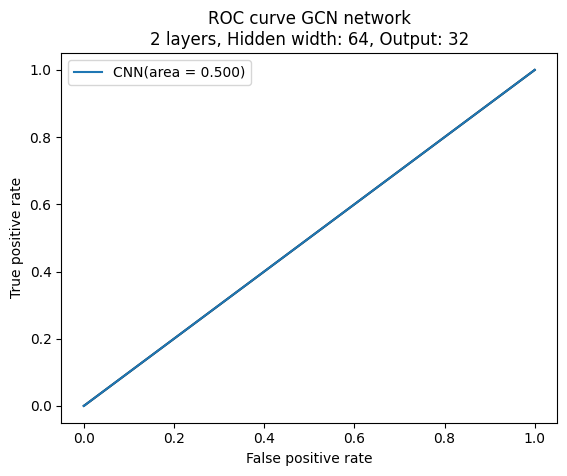

Final Test: 0.5068


In [33]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
loss_collection = []
val_auc_collection = []
last_epoch = 30
for epoch in range(1, last_epoch + 1):
    if epoch > 5:
        rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
        rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
        if rate_of_change_in_loss * -1 > 0:
            if rate_of_change_in_val * -1 > 0:
                y_true = all_labels[0]
                y_pred = all_out[0]

                fpr, tpr, _ = roc_curve(y_true, y_pred)
                roc_auc = roc_auc_score(y_true, y_pred)

                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k-')
                plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
                plt.legend(loc='best')
                plt.show()
                break
    loss = train(train_loader, epoch)
    val_auc, _, _ = test(val_loader)
    test_auc, all_labels, all_out = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    loss_collection.append(loss)
    val_auc_collection.append(val_auc)
    if epoch == last_epoch:
        y_true = all_labels[0]
        y_pred = all_out[0]

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k-')
        plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
        plt.legend(loc='best')
        plt.show()


print(f'Final Test: {final_test_auc:.4f}')

In [97]:
for name, param in model_ed.named_parameters():
    print(name, param.requires_grad)

convs.0.convs.<stops___route___stops>.bias True
convs.0.convs.<stops___route___stops>.lin.weight True
convs.0.convs.<depot___departs___stops>.lin_l.weight True
convs.0.convs.<depot___departs___stops>.lin_l.bias True
convs.0.convs.<depot___departs___stops>.lin_r.weight True
convs.0.convs.<stops___return___depot>.lin_l.weight True
convs.0.convs.<stops___return___depot>.lin_l.bias True
convs.0.convs.<stops___return___depot>.lin_r.weight True
convs.0.convs.<stops___remember___stops>.bias True
convs.0.convs.<stops___remember___stops>.lin.weight True
convs.1.convs.<stops___route___stops>.bias True
convs.1.convs.<stops___route___stops>.lin.weight True
convs.1.convs.<depot___departs___stops>.lin_l.weight True
convs.1.convs.<depot___departs___stops>.lin_l.bias True
convs.1.convs.<depot___departs___stops>.lin_r.weight True
convs.1.convs.<stops___return___depot>.lin_l.weight True
convs.1.convs.<stops___return___depot>.lin_l.bias True
convs.1.convs.<stops___return___depot>.lin_r.weight True
convs.